## LSTM, classification + regression on Spectrogram


In [13]:

from whale.data_io.data_loader import WhaleDataModule
import torch
from pytorch_lightning import seed_everything
import numpy  as np
from whale.models import LSTM
from matplotlib import pyplot as plt
from whale.utils.spectrogram import show_spectrogram

seed_everything(1234)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_path  ='/network/projects/aia/whale_call/mlruns/849777720272731425/c1309c22f4ba4734ad8c9e9ea357b9cf/artifacts/model/checkpoints/epoch=29-step=4350/epoch=29-step=4350.ckpt'
model = LSTM.load_from_checkpoint(best_model_path)
model.eval();
model.to(device);


whale_dm = WhaleDataModule(
    data_dir="/network/projects/aia/whale_call/LABELS/fw_HQ_filt_mixed", batch_size=1,data_type="spec"
)
whale_dm.setup()

ds_sel = whale_dm.valid_ds
dataset_size = len(ds_sel)



Global seed set to 1234


In [14]:
num_samples = 6
idx_rands = np.random.choice(dataset_size, num_samples)

### Results visualization


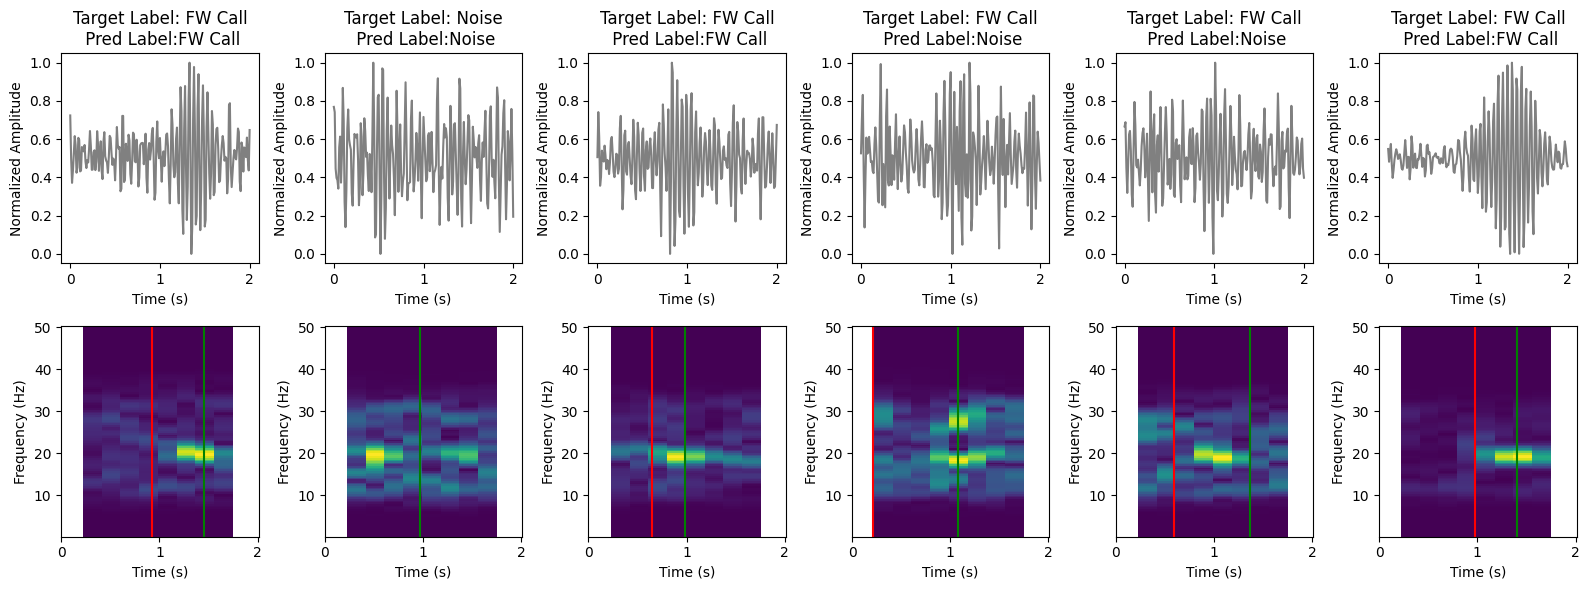

In [15]:
sig_length = 201
dt = 0.01
t_axis = np.arange(0,sig_length)*dt
label_dict = {0:'Noise',1:'FW Call'}
fig,axs = plt.subplots(2,num_samples,figsize=(16,6))
for i in range(num_samples):
    idx_rand = idx_rands[i]
    data_sel = ds_sel[idx_rand]
    sig = data_sel['sig']
    spectrogram = data_sel['spec']

    class_logits, reg_out = model(spectrogram.unsqueeze(0).to(device))
    class_pred = torch.argmax(class_logits,axis=1)
    
    axs[0][i].plot(t_axis,sig[0],color='grey');
    axs[0][i].set_title(f"Target Label: {label_dict[data_sel['target_label']]}\n Pred Label:{label_dict[class_pred.cpu().detach().numpy()[0]]}")
    # add axis labels
    axs[0][i].set_xlabel('Time (s)')
    axs[0][i].set_ylabel('Normalized Amplitude')

    # plot spectrogram and add vertical lines representing target time and predicted time
    show_spectrogram(sig[0],axes=axs[1][i],samp_rate=100,per_lap=0.9, wlen=0.5, mult=4)
    axs[1][i].axvline(x=data_sel['target_time'],color='red')
    axs[1][i].axvline(x=reg_out.cpu().detach().numpy(),color='green')
    # add axis labels
    axs[1][i].set_xlabel('Time (s)')
    axs[1][i].set_ylabel('Frequency (Hz)')
    # show legend
    # axs[1][i].legend(['t_trgt','t_pred'])

plt.tight_layout()
# fig.savefig('prediction_examples_baseline_LSTM_cls_reg.png',dpi=300)


### Histograms and confusion matrix (Warning: Long runtime)

In [ ]:
from pytorch_lightning import Trainer
import numpy as np
test_loader = whale_dm.test_dataloader()
test_size = len(test_loader)
trainer = Trainer( accelerator='auto')
model =LSTM(input_dim= 129 ,hidden_dim=128,reg_loss_weight=0.5,num_layers=3,bidirectional=False)
prediction_output=trainer.predict(model, dataloaders=test_loader, ckpt_path=best_model_path)
label_pred=np.vstack([prediction['label'].reshape(-1,1).numpy() for prediction in prediction_output])
time_pred=np.vstack([prediction['time'].reshape(-1,1).numpy()   for prediction in prediction_output])

label_true = []
time_true = []
for batch in test_loader:
    label_true.append(batch['target_label'].reshape(-1,1).numpy())
    time_true.append(batch['target_time'].reshape(-1,1).numpy())
label_true = np.vstack([label.reshape(-1,1) for label in label_true])
time_true = np.vstack([time.reshape(-1,1) for time in time_true])